In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-04-08 18:04:23.286409: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 18:04:28.717171: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 18:04:28.722397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 18:04:29.567791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 18:04:31.891752: I tensorflow/core/platform/cpu_feature_guar

2.15.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-04-08 18:05:50.652734: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 18:05:50.829201: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 18:05:50.829235: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import keras
print(keras.__version__)

3.0.0


In [3]:
import tensorflow_datasets as tfds
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:


# (training_set, test_set, validation_set), dataset_info = tfds.load('kitti',
#                                                          split=['train[:80%]', 'train[80:90%]', 'train[90%:]'],
#                                                         #  download=True,
#                                                          with_info=True,
#                                                          )
# print(f"Number of training samples: {training_set.cardinality()}")
# print(f"Number of validation samples: {validation_set.cardinality()}")
# print(f"Number of test samples: {test_set.cardinality()}")
# (test_set, validation_set), dataset_info = tfds.load('kitti',
#             split=['test', 'validation'],
#         #  download=True,
#         with_info=True,
#             )

In [ ]:
def cut_image(image, box):
        h,w,ch = image.shape
        ymin, xmin, ymax, xmax = box
        ymin, xmin, ymax, xmax = h-int(ymin*h), int(xmin*w), h-int(ymax*h), int(xmax*w)                
        object = image[ymax:ymin, xmin:xmax, :]
        
        if object.shape[1]==0 or object.shape[0]==0:                
            print("error with image shape")
        return object

def transform_dataset(ds, ds_path, ds_name, ds_type, info):

    # create ds directory if not exists
    save_path = os.path.join(ds_path, ds_name, ds_type)
    os.makedirs(save_path, exist_ok=True)
    # create classes folders if not exist
    names = np.asarray(info.features["objects"]["type"].names)
    for name in names:
        os.makedirs(os.path.join(save_path, name), exist_ok=True)
    
    for el in ds:
        image = el["image"].numpy()
        image_name = bytes.decode(el["image/file_name"].numpy())
        boxes = el["objects"]["bbox"]
        classes = el["objects"]["type"]
        for i, (box, label) in enumerate(zip(boxes, classes)):
            file_name = os.path.join(save_path, names[label], str(i)+image_name)
            cv2.imwrite(file_name, cut_image(image, box))

In [ ]:
# uncomment to transform datasets
path = os.path.join(os.getcwd(), "dataset")   
# transform_dataset(training_set.skip(0).take(1000), path, 'kitti', 'train', dataset_info)
# transform_dataset(test_set.skip(0).take(1000), path, 'kitti', 'test', dataset_info)

In [5]:
IMAGE_RES = 224
BATCH_SIZE = 64

train_ds, valid_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/train/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES),
    validation_split=0.2,
    seed=121,
    subset="both"
)

Found 14136 files belonging to 8 classes.
Using 11309 files for training.
Using 2827 files for validation.


In [6]:
test_ds = keras.utils.image_dataset_from_directory(
    "dataset/kitti/test/",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_RES, IMAGE_RES)
)

Found 3958 files belonging to 8 classes.


In [7]:
class_names = np.asarray(['Car', 'Cyclist', 'Misc', 'Pedestrian', 'Person_sitting', 'Tram', 'Truck', 'Van'])
NUM_CLASSES = len(class_names)

In [ ]:
labels = list(train_ds.unbatch().map(lambda x,y: y).as_numpy_iterator())
# print(labels)
classes, counts = np.unique(labels, return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
plt.bar(class_names[classes], counts) 

In [8]:
def plot_batch(ds,num):

    plt.figure(figsize=(10, 10))
    image_batch, label_batch = next(iter(ds.take(1)))
    image_batch = image_batch.numpy().astype(int)
    label_batch = label_batch.numpy()
        
    for i in range(num):
        ax = plt.subplot(int(np.sqrt(num)), int(np.sqrt(num)), i + 1)
        plt.imshow(image_batch[i])
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

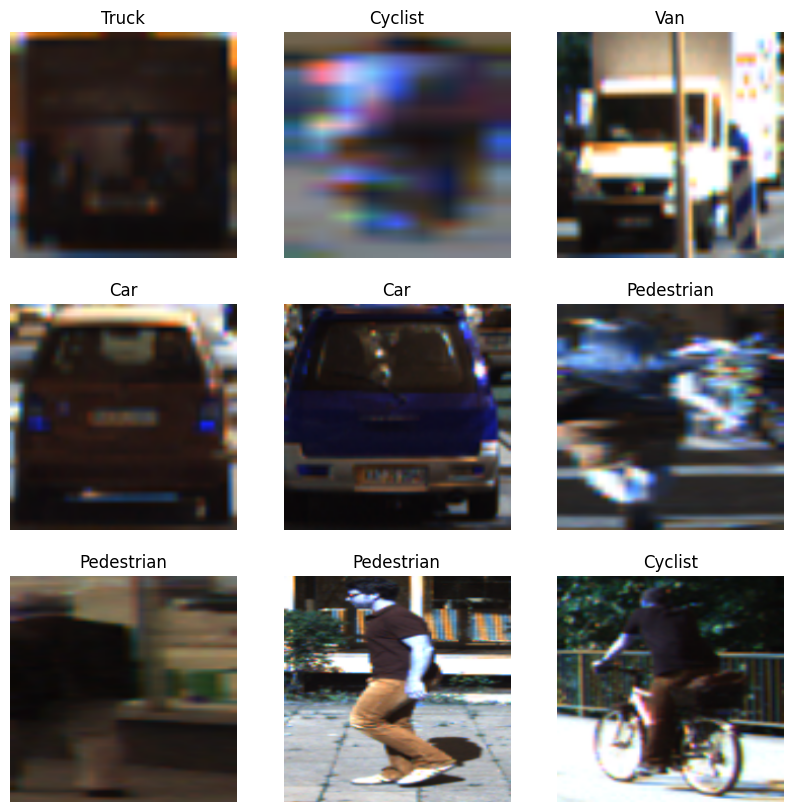

In [9]:
plot_batch(train_ds,9)

In [10]:
augmenter = keras.Sequential(
    [
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomTranslation(0.1,0.1),
        keras.layers.RandomZoom(0.1,0.1)
    ],
)

def preprocess_data(images, labels, augment=False):
    if augment:
        images = augmenter(images)
    return images, labels

In [11]:
train_batched_dataset = train_ds.map(lambda x, y: preprocess_data(x, y, augment=True)).prefetch(1)

In [12]:
valid_batched_dataset = valid_ds.prefetch(1)

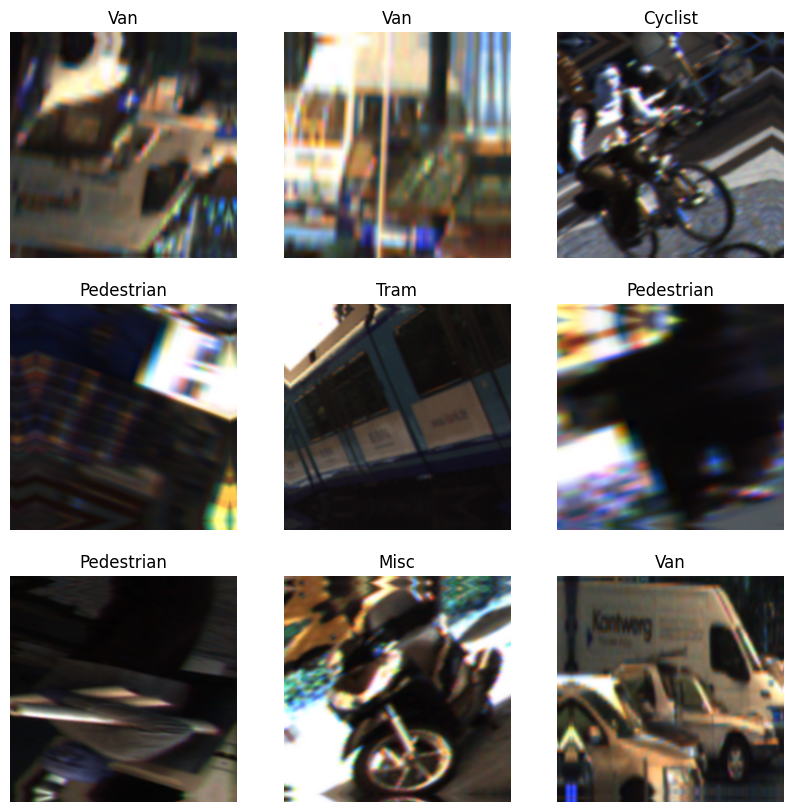

In [13]:
plot_batch(train_batched_dataset,9)
# plot_batch(train_ds,25)

In [14]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(IMAGE_RES, IMAGE_RES, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

# Pre-trained MobileNetV2 weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)
# or map dataset with this function:
# def preprocess(images, labels):
#   return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.summary(show_trainable=True)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape             ┃ Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ rescaling (Rescaling)       │ (None, 224, 224, 3)      │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ mobilenetv2_1.00_224        │ (None, 7, 7, 1280)       │ 2,257,… │   N   │
│ (Functional)                │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ global_average_pooling2d    │ (None, 1280)             │       0 │   -   │
│ (GlobalAveragePooling2D)    │                          │         │       │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dropout (Dropout)           │ (None, 1280)             │       0 │   -   │
├─────────────────────────────┼──────────────────────────┼─────────┼───────┤
│ dense (Dense)               │ (None, 8)                │  10,248 │   Y   │
└─────────────────────────────┴──────────────────────────┴─────────┴───────┘

 Total params: 2,268,232 (8.65 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
model.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=7),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 60
print("Fitting the top layer of the model")
history = model.fit(train_batched_dataset, epochs=epochs, validation_data=valid_batched_dataset, callbacks=my_callbacks)

Fitting the top layer of the model
Epoch 1/60


2024-04-08 18:13:30.693835: I external/local_xla/xla/service/service.cc:168] XLA service 0x560da7d1aac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-08 18:13:30.693894: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2024-04-08 18:13:31.114630: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-08 18:13:32.133041: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1712592843.378613    3218 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


177/177 ━━━━━━━━━━━━━━━━━━━━ 206s 970ms/step - loss: 1.6013 - sparse_categorical_accuracy: 0.4626 - val_loss: 1.0015 - val_sparse_categorical_accuracy: 0.6859
Epoch 2/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 167s 942ms/step - loss: 1.0407 - sparse_categorical_accuracy: 0.6516 - val_loss: 0.8547 - val_sparse_categorical_accuracy: 0.7382
Epoch 3/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 159s 891ms/step - loss: 0.9339 - sparse_categorical_accuracy: 0.6792 - val_loss: 0.8021 - val_sparse_categorical_accuracy: 0.7492
Epoch 4/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 152s 854ms/step - loss: 0.8795 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.7430 - val_sparse_categorical_accuracy: 0.7665
Epoch 5/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 155s 872ms/step - loss: 0.8535 - sparse_categorical_accuracy: 0.7051 - val_loss: 0.7243 - val_sparse_categorical_accuracy: 0.7680
Epoch 6/60
177/177 ━━━━━━━━━━━━━━━━━━━━ 152s 851ms/step - loss: 0.8032 - sparse_categorical_accuracy: 0.7205 - val_loss: 0.6951 - val_sparse_categorical_accuracy

In [16]:
import os
model.save(os.path.join(os.getcwd(), "models", "model_kitti_sgd_55ep.keras"))

In [17]:
def plot_hist(hist):
    acc = hist.history['sparse_categorical_accuracy']
    val_acc = hist.history['val_sparse_categorical_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs_range = hist.epoch

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

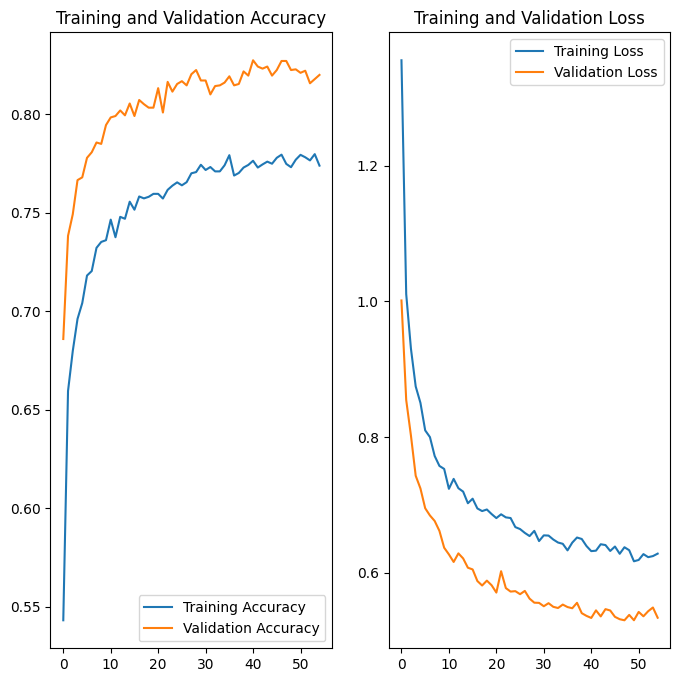

In [18]:
plot_hist(history)

In [19]:
test_batches = test_ds.prefetch(1)

In [20]:
loss, accuracy = model.evaluate(test_batches)
print('Test accuracy :', accuracy)

62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 471ms/step - loss: 1.0114 - sparse_categorical_accuracy: 0.6613
Test accuracy : 0.6581606864929199


In [ ]:
model_sgd = model
model_sgd.compile(
    optimizer=keras.optimizers.SGD(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

my_callbacks = [
    keras.callbacks.EarlyStopping(patience=5),
    keras.callbacks.TensorBoard(log_dir='./logs'),
]

epochs = 20
print("Fitting the top layer of the model")
history_sgd = model_sgd.fit(train_batched_dataset, epochs=epochs, validation_data=valid_batched_dataset, callbacks=my_callbacks)

In [ ]:
model_sgd.save(os.path.join(os.getcwd(), "models", "model_kitti_sgd_20epoch.keras"))

In [ ]:
plot_hist(history_sgd)

In [ ]:
loss, accuracy = model_sgd.evaluate(test_batches)
print('Test accuracy :', accuracy)

In [ ]:
ADD_EPOCHS = 20
TOTAL_EPOCHS =  epochs + ADD_EPOCHS
model_sgd2 = model_sgd
history_sgd2 = model_sgd2.fit(train_batched_dataset,
                         epochs=TOTAL_EPOCHS,
                         initial_epoch=history_sgd.epoch[-1],
                         validation_data=valid_batched_dataset,
                         callbacks=my_callbacks)

In [ ]:
# history_sgd.history + history_sgd2.history
plot_hist(history_sgd2)

In [ ]:
loss, accuracy = model_sgd2.evaluate(test_batches)
print('Test accuracy :', accuracy)